<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>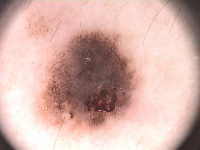</td><td>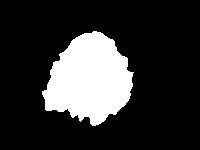</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!pip install googledrivedownloader

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1VtEDXKLJSe0-x3RnQvlvZZv9bqKMte0h',
                                    dest_path='./PH2Dataset.rar',
                                    unzip=False)

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

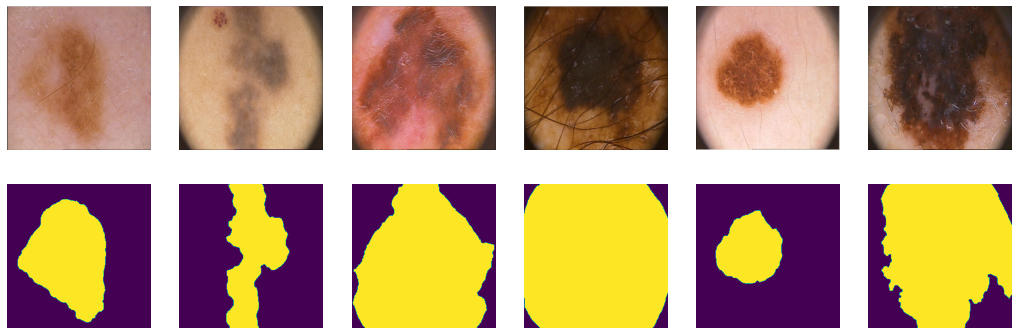

(256, 256)

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();
Y[0].shape

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
import torch
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
import pickle

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
batch_size = 20
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def test_model(Model, image_size=256): 
    test_model = Model()
    summary(test_model.cuda(), (3, image_size, image_size))
    del test_model 
    torch.cuda.empty_cache()

In [ ]:
def loss_plot(train_loss, val_loss): 
    plt.figure(figsize=(16, 8))
    plt.plot(train_loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.grid()
    plt.show()

In [ ]:
def score_plot(train_score, val_score): 
    plt.figure(figsize=(16, 8))
    plt.plot(train_score, label="train_score")
    plt.plot(val_score, label="val_score")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("score")
    plt.grid()
    plt.show()

In [ ]:
def save_obj(obj, file_name): 
    afile = open(file_name + '.pkl', 'wb')
    pickle.dump(obj, afile)
    afile.close()

def load_obj(file_name):
    afile = open(file_name + '.pkl', 'rb')
    res = pickle.load(afile)
    afile.close()
    return res

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

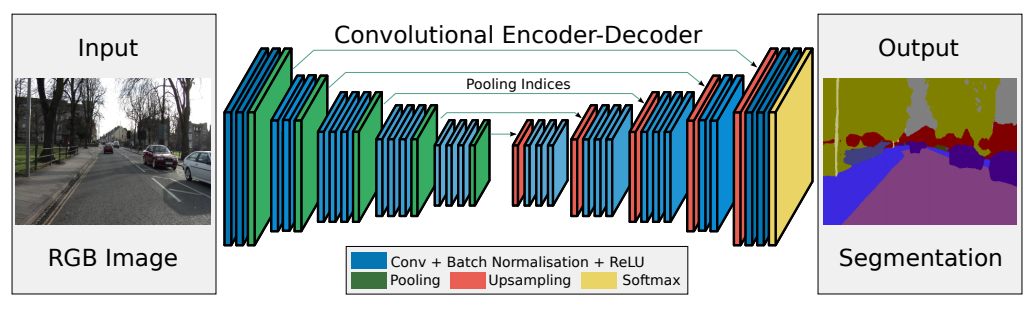

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)   # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        ) 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.bottleneck_unpool = nn.MaxUnpool2d(2, stride=2)
        self.bottleneck_deconv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.MaxUnpool2d(2, stride=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.MaxUnpool2d(2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        ) 
        self.upsample3 = nn.MaxUnpool2d(2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        x, id0 = self.pool0(self.enc_conv0(x))
        x, id1 = self.pool1(self.enc_conv1(x))
        x, id2 = self.pool2(self.enc_conv2(x))
        x, id3 = self.pool3(self.enc_conv3(x))

        # bottleneck
        x, idb = self.bottleneck_pool(self.bottleneck_conv(x))

        x = self.bottleneck_deconv(self.bottleneck_unpool(x, idb))

        # decoder
        x = self.dec_conv0(self.upsample0(x, id3))
        x = self.dec_conv1(self.upsample1(x, id2))
        x = self.dec_conv2(self.upsample2(x, id1))
        x = self.dec_conv3(self.upsample3(x, id0))
        return x

In [ ]:
test_model(SegNet)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14  [[

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    # thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return iou 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    y_pred = torch.clamp(y_pred, min=-50, max=50)
    loss = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))
    return torch.sum(loss)

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train_epoch(model, opt, loss_fn, data_tr): 
    avg_loss_tr = 0
    train_size = 0

    model.train()  # train mode
    for X_batch, Y_batch in data_tr:
        # data to device
        train_size = X_batch.shape[0]
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        # set parameter gradients to zero
        opt.zero_grad()

        # forward
        Y_pred = model(X_batch)
        loss = loss_fn(Y_batch, Y_pred)
        loss.backward()
        opt.step()
        
        # calculate loss to show the user 
        avg_loss_tr += loss.item()

    avg_loss_tr /= (train_size)
    return avg_loss_tr

In [ ]:
def eval_epoch(model, loss_fn, data_val): 
    avg_loss_val = 0
    val_size = 0

    model.eval()  # testing mode
    for X_batch, Y_batch in data_val: 
        val_size = X_batch.shape[0]
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        with torch.set_grad_enabled(False):
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
        
        avg_loss_val += loss.item()
    avg_loss_val /= (val_size)
    return avg_loss_val

In [ ]:
def train(model, opt, loss_fn, metric, epochs, data_tr, data_val, show_flag = True):
    X_val, Y_val = next(iter(data_val))
    train_losses = []
    val_losses = []
    scores_train = []
    scores_val = []

    
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss_tr = train_epoch(model, opt, loss_fn, data_tr)
        train_losses.append(avg_loss_tr)
        
        avg_loss_val = eval_epoch(model, loss_fn, data_val)
        val_losses.append(avg_loss_val)
        

        train_score = score_model(model, metric, data_tr)
        scores_train.append(train_score)
        
        val_score = score_model(model, metric, data_val)
        scores_val.append(val_score)
        
        

        # Visualize tools
        clear_output(wait=True)
        
        if (show_flag):
            Y_hat = torch.sigmoid(model(X_val[:6].to(device))).to('cpu').detach()
            Y_hat_res = Y_hat > 0.5
            plt.figure(figsize=(16, 9))
            for k in range(6):
                plt.subplot(4, 6, k+1)
                plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')

                plt.subplot(4, 6, k+7)
                plt.imshow(Y_val[k, 0], cmap='gray')
                plt.title('Ground Truth')
                plt.axis('off')

                plt.subplot(4, 6, k+13)
                plt.imshow(Y_hat[k, 0], cmap='gray')
                plt.title('Output')
                plt.axis('off')

                plt.subplot(4, 6, k+19)
                plt.imshow(Y_hat_res[k, 0], cmap='gray')
                plt.title('Output')
                plt.axis('off')
            plt.suptitle('Epoch %d / %d' % (epoch+1, epochs))
            plt.show()
        print('loss train: %f' % avg_loss_tr)
        print('loss vall: %f' % avg_loss_val)
        print('train score: %f' % train_score)
        print('val score: %f' % val_score)
    return train_losses, scores_train, val_losses, scores_val

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch.to(device))) > 0.5
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores / len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model = SegNet().to(device)

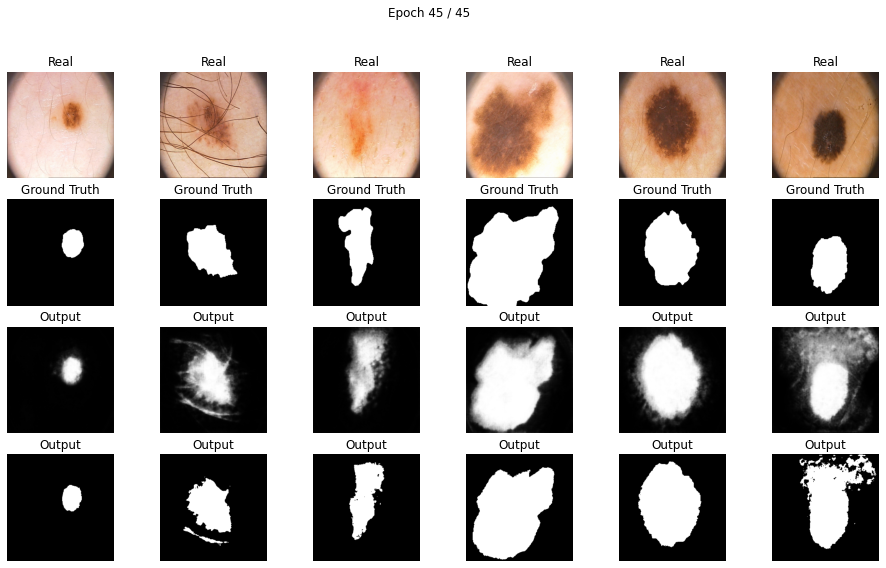

loss train: 63990.770312
loss vall: 68204.065625
train score: 0.805034
val score: 0.728961


In [ ]:
max_epochs = 45
optim = torch.optim.Adam(model.parameters())
history_bce = train(model, optim, bce_loss, iou_pytorch, max_epochs, data_tr, data_val, True)

In [ ]:
train_loss, train_score, val_loss, val_score = history_bce

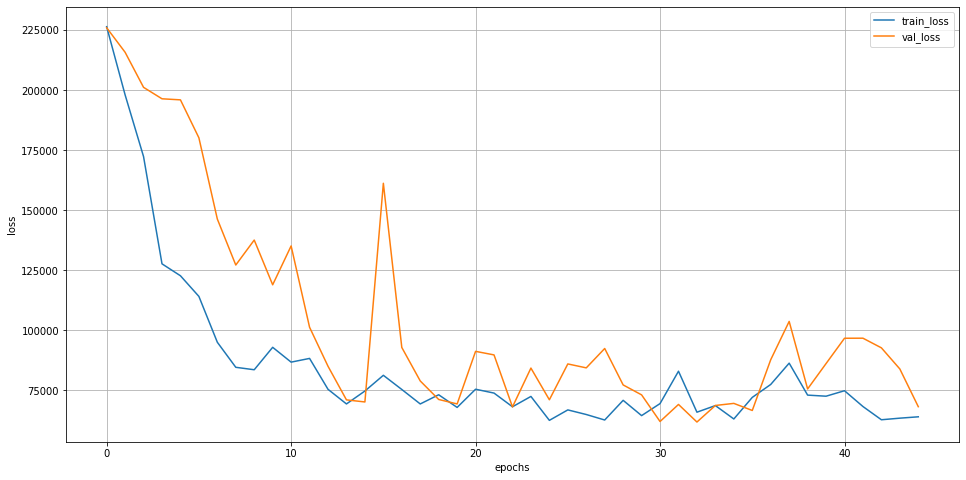

In [ ]:
loss_plot(train_loss, val_loss)

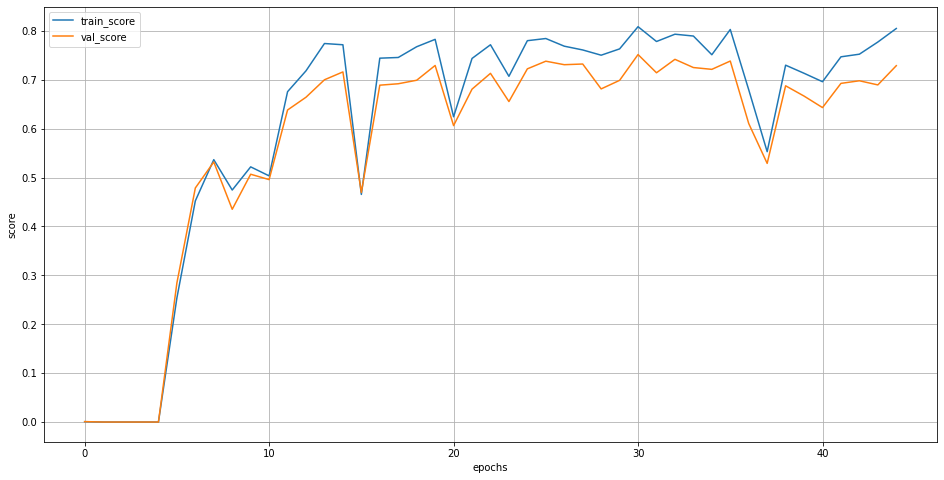

In [ ]:
score_plot(train_score, val_score)

In [ ]:
score_model(model, iou_pytorch, data_ts)

0.7886990904808044

Ответьте себе на вопрос: не переобучается ли моя модель?

На основе графиков, можно сделать вывод, что модель не переобучается, так как разница между *score* на обучающей выборке и валидационной почти на всем времени обучения остается постоянной, а также *score* на валидационной выборке постоянно растет.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred):
    eps = 1e-8
    y_pred = torch.clamp(y_pred, -50, 50) # hint: torch.clamp
    y_pred = torch.sigmoid(y_pred)
    up = (2 * y_real * y_pred)
    down = (y_real + y_pred) 
    up = up.sum(dim=(2, 3))
    down = down.sum(dim=(2, 3))
    res = 1 - (up + eps) / (down + eps)
    return torch.sum(res)

Проводим тестирование:

In [ ]:
model_dice = SegNet().to(device)

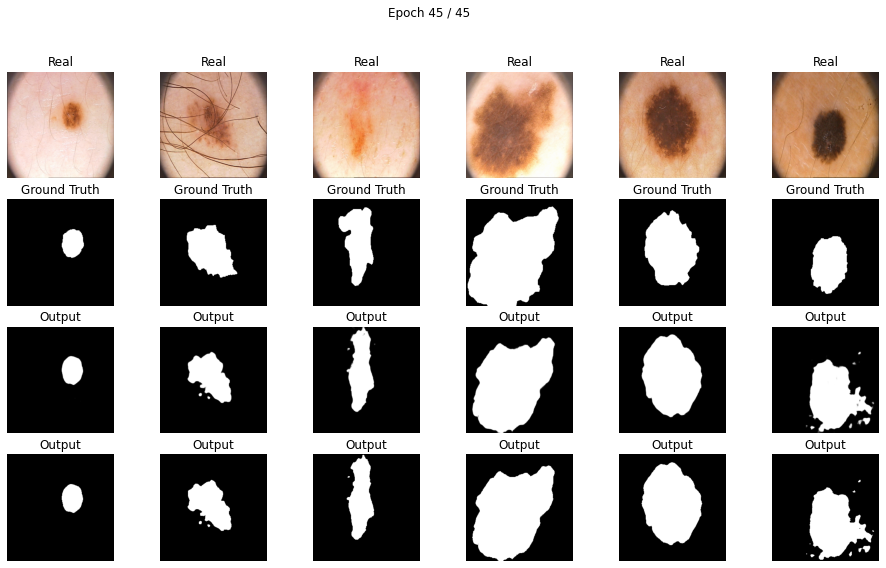

loss train: 0.393375
loss vall: 0.660870
train score: 0.808958
val score: 0.766092


In [ ]:
max_epochs = 45
optimaizer = torch.optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, iou_pytorch, max_epochs, data_tr, data_val);

In [ ]:
score_model(model_dice, iou_pytorch, data_ts)

0.8042032718658447

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.clamp(y_pred, -50, 50) # hint: torch.clamp
    sigm_pred = torch.sigmoid(y_pred)
    loss = -((1 - sigm_pred)**gamma * y_real * torch.log(sigm_pred + eps) + 
             (1 - y_real) * torch.log(1 - sigm_pred + eps))
    return torch.sum(loss)

In [ ]:
model_focal = SegNet().to(device)

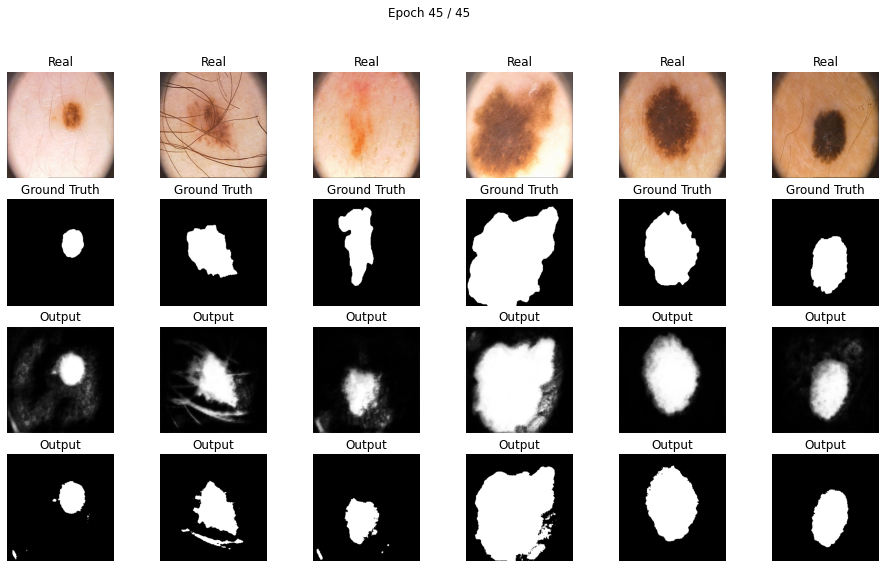

loss train: 0.505407
loss vall: 0.629038
train score: 0.758723
val score: 0.752837


In [ ]:
max_epochs = 45
optimaizer = torch.optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, loss_all, iou_pytorch,  max_epochs, data_tr, data_val);

In [ ]:
score_model(model_focal, iou_pytorch, data_ts)

0.7643527388572693

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

#### Реализация *ssl_loss*

In [ ]:
def ce_loss(y_real, y_pred): 
    eps = 1e-5
    return -(y_real * torch.log(y_pred + eps) + (1 - y_real) * torch.log(1 - y_pred + eps))

In [ ]:
def ssl_subloss(y_real, y_pred): 
    beta = 0.1
    smooth = 1e-2
    e_max = 5.48241
    m_r = F.avg_pool2d(y_real, kernel_size=3, stride=1, padding=1) 
    m_p = F.avg_pool2d(y_pred, kernel_size=3, stride=1, padding=1) 
    std_r = torch.sqrt(F.avg_pool2d(y_real * y_real, kernel_size=3, stride=1, padding=1) - m_r * m_r + smooth)
    std_p = torch.sqrt(F.avg_pool2d(y_pred * y_pred, kernel_size=3, stride=1, padding=1) - m_p * m_p + smooth)
    e = torch.abs((y_real - m_r + smooth) / (std_r + smooth) - 
                  (y_pred - m_p + smooth) / (std_p + smooth))
    f = e > (beta * e_max)
    loss_matrix = e * f * ce_loss(y_real, y_pred)
    M = torch.sum(f)
    loss = torch.sum(loss_matrix)
    return (M, loss)

In [ ]:
def ssl_loss(y_real, y_pred):
     smooth = 1e-2
     M, loss = ssl_subloss(y_real, y_pred)
     return loss / (M + smooth)

In [ ]:
def loss_all(y_real, y_pred): 
     lambdac = 0.5
     y_pred = torch.clamp(y_pred, min=-50, max=50)
     y_pred = torch.sigmoid(y_pred)
     ssl_loss_ = ssl_loss(y_real, y_pred)
     ce_loss_ = torch.sum(ce_loss(y_real, y_pred))
     return lambdac * ce_loss_ / (256 * 256) + (1 - lambdac) * ssl_loss_

#### Проверка *ssl_loss*

In [ ]:
model_ssl = SegNet().to(device)

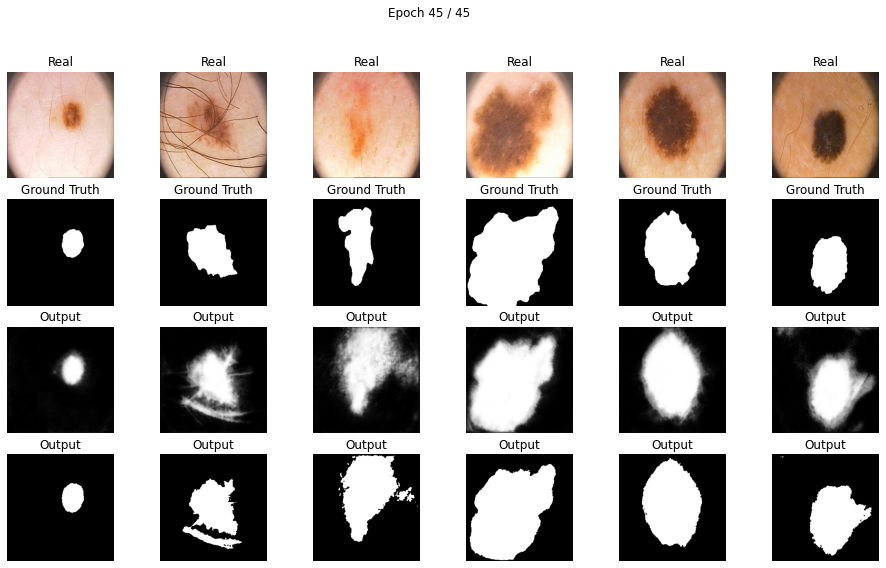

loss train: 0.483741
loss vall: 0.501518
train score: 0.834477
val score: 0.785159


In [ ]:
max_epochs = 45
optimaizer = torch.optim.Adam(model_ssl.parameters())
train(model_ssl, optimaizer, loss_all, iou_pytorch,  max_epochs, data_tr, data_val);

In [ ]:
score_model(model, iou_pytorch, data_ts)

0.7886990904808044

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

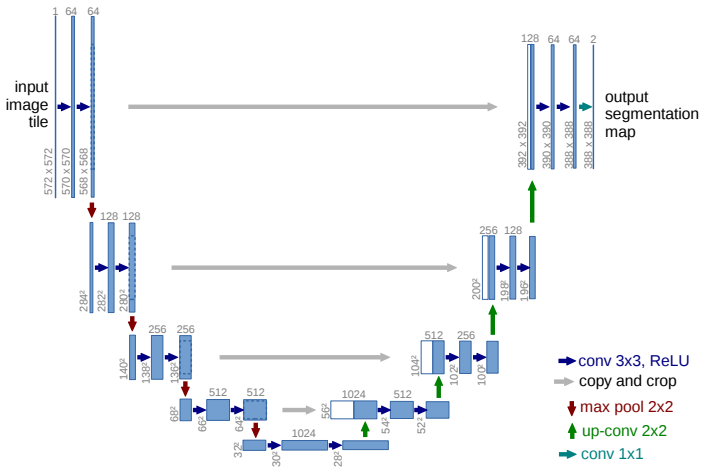

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)   # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        ) 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.bottleneck_unpool = nn.MaxUnpool2d(2, stride=2)
        self.bottleneck_deconv = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )


        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.MaxUnpool2d(2, stride=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.MaxUnpool2d(2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        ) 
        self.upsample3 = nn.MaxUnpool2d(2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        x, id0 = self.pool0(e0)

        e1 = self.enc_conv1(x)
        x, id1 = self.pool1(e1)

        e2 = self.enc_conv2(x)
        x, id2 = self.pool2(e2)

        e3 = self.enc_conv3(x)
        x, id3 = self.pool3(e3)

        # bottleneck
        bc = self.bottleneck_conv(x)
        x, idb = self.bottleneck_pool(bc)

        bd = self.bottleneck_deconv(
            torch.cat((bc, self.bottleneck_unpool(x, idb)), 1))

        # decoder
        d0 = self.dec_conv0(torch.cat((e3, 
                                       self.upsample0(bd, id3)), 1))
        d1 = self.dec_conv1(torch.cat((e2, 
                                      self.upsample1(d0, id2)), 1))
        d2 = self.dec_conv2(torch.cat((e1, 
                                      self.upsample2(d1, id1)), 1))
        d3 = self.dec_conv3(torch.cat((e0,
                                      self.upsample3(d2, id0)), 1))
        return d3

In [ ]:
test_model(UNet)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14  [[

In [ ]:
unet_model = UNet().to(device)

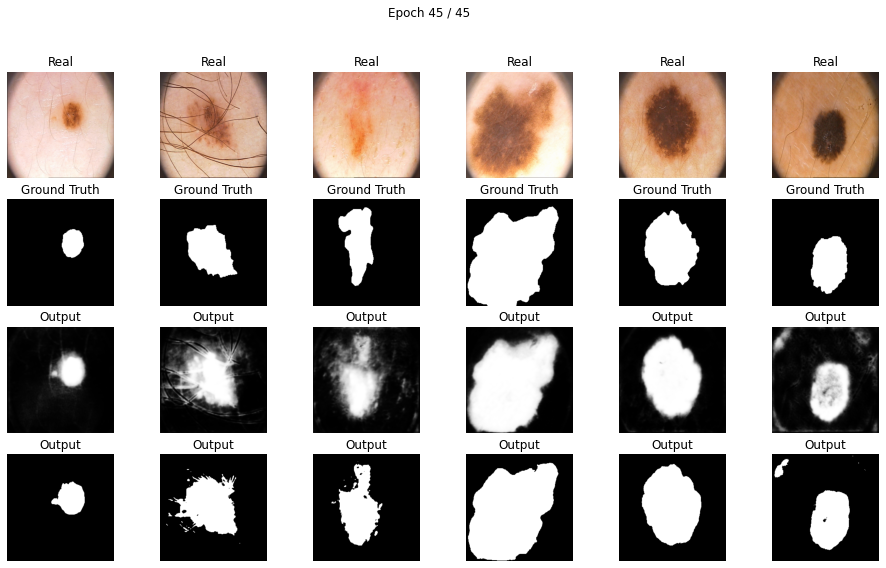

loss train: 47709.541406
loss vall: 65856.068750
train score: 0.827350
val score: 0.783156


In [ ]:
max_epochs = 45
opt_unet = torch.optim.Adam(unet_model.parameters())
history_unet = train(unet_model, opt_unet, bce_loss, iou_pytorch, max_epochs, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_ts)

0.8134902517000834

In [ ]:
train_loss, train_score, val_loss, val_score = history_unet

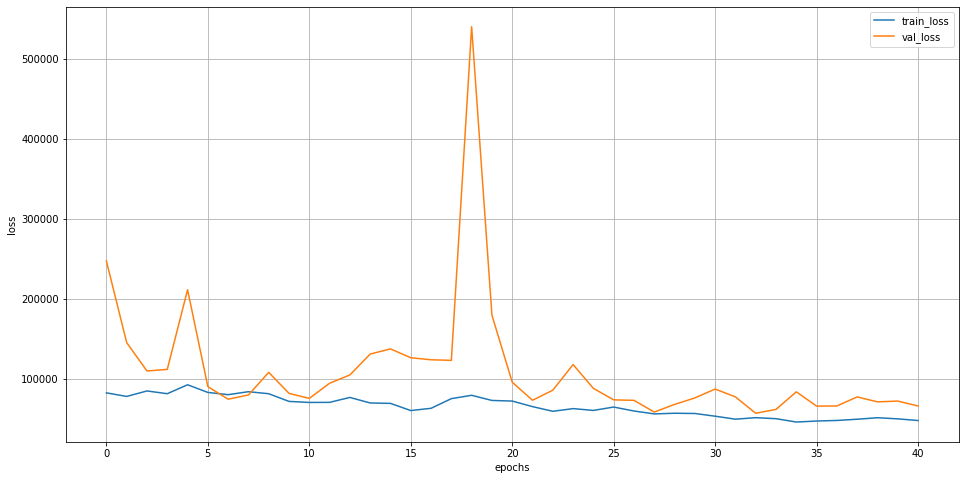

In [ ]:
loss_plot(train_loss[4:], val_loss[4:]) # first losses ~ 1e6

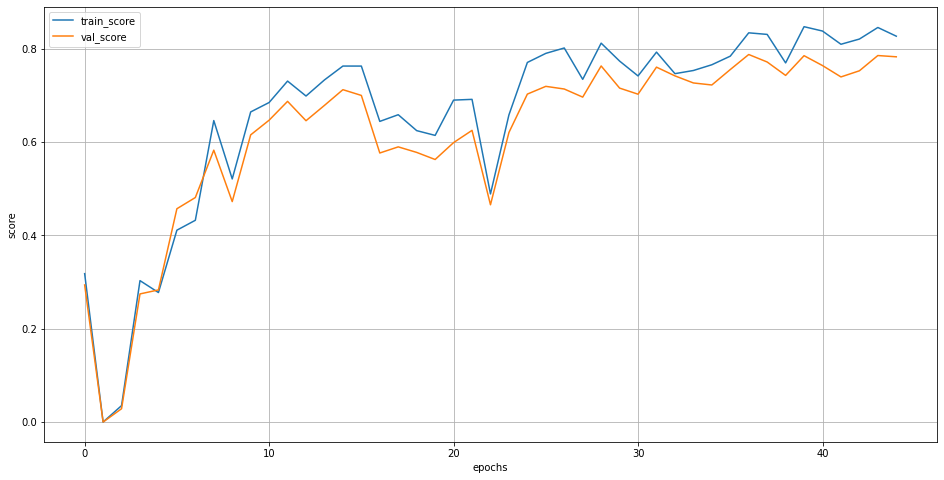

In [ ]:
score_plot(train_score, val_score)

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)   # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        ) 
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.bottleneck_pool = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=2)
        self.bottleneck_unpool = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2)
        self.bottleneck_deconv = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        ) 
        self.upsample3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        x = self.pool0(e0)

        e1 = self.enc_conv1(x)
        x = self.pool1(e1)

        e2 = self.enc_conv2(x)
        x = self.pool2(e2)

        e3 = self.enc_conv3(x)
        x = self.pool3(e3)

        # bottleneck
        bc = self.bottleneck_conv(x)
        x = self.bottleneck_pool(bc)

        bd = self.bottleneck_deconv(
            torch.cat((bc, 
                       self.bottleneck_unpool(x)), 1))

        # decoder
        # print(e3.shape, self.upsample0(bd).shape)
        d0 = self.dec_conv0(torch.cat((e3, 
                                       self.upsample0(bd)), 1))
        # print(e2.shape, self.upsample1(d0).shape)
        d1 = self.dec_conv1(torch.cat((e2, 
                                      self.upsample1(d0)), 1))
        # print(e1.shape, self.upsample2(d1).shape)
        d2 = self.dec_conv2(torch.cat((e1, 
                                      self.upsample2(d1)), 1))
        # print(e0.shape, self.upsample3(d2).shape)
        d3 = self.dec_conv3(torch.cat((e0,
                                      self.upsample3(d2)), 1))
        return d3

In [ ]:
test_model(UNet2)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
            Conv2d-7         [-1, 64, 128, 128]          16,448
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
           Conv2d-14          [-1, 128,

In [ ]:
unet2_model = UNet2().to(device)

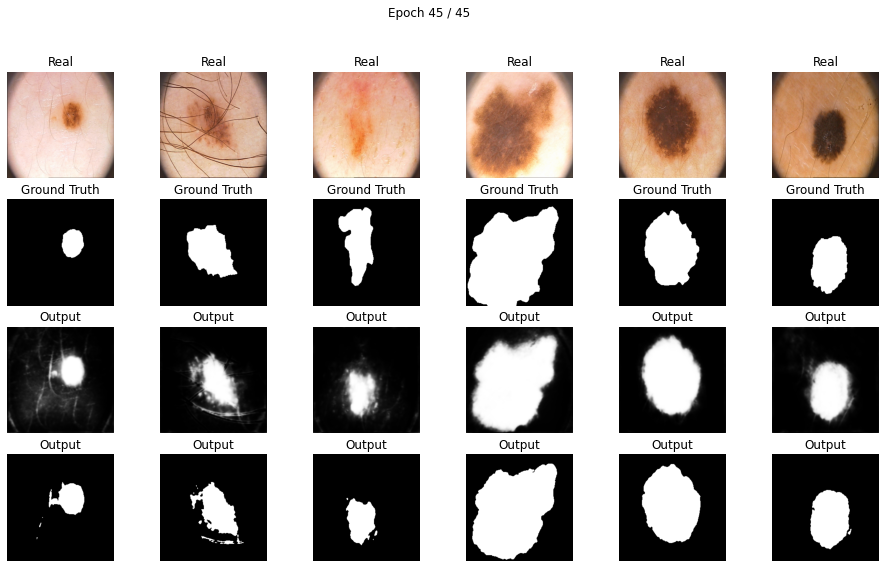

loss train: 44489.261719
loss vall: 67815.409375
train score: 0.818597
val score: 0.770866


In [ ]:
max_epochs = 45
opt_unet2 = torch.optim.Adam(unet2_model.parameters())
history_unet2 = train(unet2_model, opt_unet2, bce_loss, iou_pytorch, max_epochs, data_tr, data_val)

In [ ]:
score_model(unet2_model, iou_pytorch, data_ts)

0.7899610797564188

In [ ]:
train_loss, train_score, val_loss, val_score = history_unet2

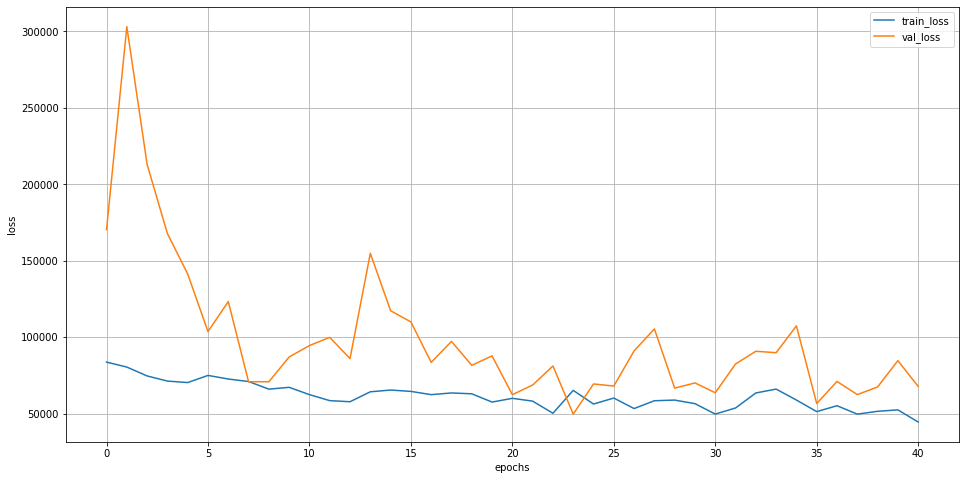

In [ ]:
loss_plot(train_loss[4:], val_loss[4:])

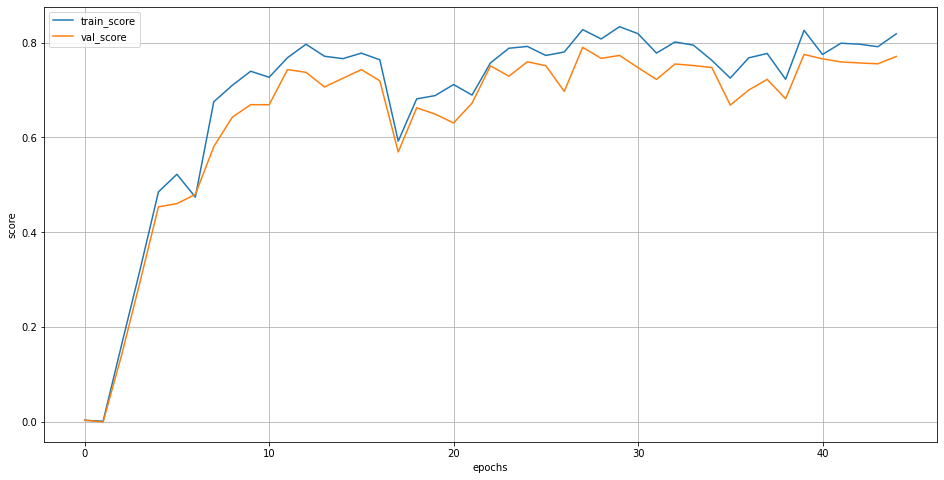

In [ ]:
score_plot(train_score, val_score)

Сделайте вывод, какая из моделей лучше

# Анализ 

Всего у нас есть 4 различные *loss*-функции: *bce_loss*, *dice_loss*, *focal_loss*, *ssl_loss*, а также 3 модели: *SegNet*, *UNet*, *UNet2*. Обучим каждую модель со всеми *loss*-функциями одинаковое количество эпох (60). По результатам обучения выберем пару (модель,  *loss*-функция) с лучшим результатом на тестовой выборке, a также оценим, какие модели более стабильны при обучении.

In [ ]:
last_label = ''

def measure(Model, model_name, losses, data_tr, data_val, data_ts, epoches=60):
    global last_label 
    train_res = {}
    test_res = {}
    last_label = ''
    for label, loss in losses.items(): 
        model = Model().to(device)
        train_res[label] = train(model, torch.optim.Adam(model.parameters()), 
                                 loss, iou_pytorch, epoches, data_tr, data_val, False)
        test_res[label] = score_model(model, iou_pytorch, data_ts)
        del model 
        torch.cuda.empty_cache()
        last_label = label
        save_obj(train_res, model_name + '_train')
        save_obj(test_res, model_name + '_test')
    return train_res, test_res

In [ ]:
losses = {'bce_loss': bce_loss, 
          'dice_loss': dice_loss, 
          'focal_loss': focal_loss, 
          'ssl_loss': loss_all}

In [ ]:
segnet_res = measure(SegNet, 'SegNet', losses, data_tr, data_val, data_ts)
tr_res_segnet, test_res_segnet = segnet_res

loss train: 0.412774
loss vall: 0.762269
train score: 0.773308
val score: 0.720024


In [ ]:
test_res_segnet

{'bce_loss': 0.820145825544993,
 'dice_loss': 0.823737641175588,
 'focal_loss': 0.759093701839447,
 'ssl_loss': 0.785057266553243}

In [ ]:
unet_res = measure(UNet, 'UNet', losses, data_tr, data_val, data_ts)
tr_res_unet, test_res_unet = unet_res

loss train: 0.493522
loss vall: 0.536147
train score: 0.848806
val score: 0.811292


In [ ]:
test_res_unet

{'bce_loss': 0.8391981919606527,
 'dice_loss': 0.8313691814740499,
 'focal_loss': 0.834553082784017,
 'ssl_loss': 0.834554930528005}

In [ ]:
unet2_res = measure(UNet2, 'UNet2', losses, data_tr, data_val, data_ts)
tr_res_unet2, test_res_unet2 = unet2_res

loss train: 0.338291
loss vall: 0.392819
train score: 0.881237
val score: 0.853317


In [ ]:
test_res_unet2

{'bce_loss': 0.8186835050582886,
 'dice_loss': 0.7569368481636047,
 'focal_loss': 0.8031632701555887,
 'ssl_loss': 0.8647440075874329}

### Графики

Построим графики *score* на валидационной выборке разных моделей с разными *loss*-функциями. Также выделим максимальный *score* среди всей истории обучения для каждой пары (модель, *loss*-функция)

In [ ]:
segnet_train_score = {}
segnet_val_score = {}
for label in losses.keys(): 
    _, segnet_train_score[label], _, segnet_val_score[label] = np.array(tr_res_segnet[label])

In [ ]:
unet_train_score = {}
unet_val_score = {}
for label in losses.keys(): 
    _, unet_train_score[label], _, unet_val_score[label] = np.array(tr_res_unet[label])

In [ ]:
unet2_train_score = {}
unet2_val_score = {}
unet2_diff_score = {}
for label in losses.keys(): 
    _, unet2_train_score[label], _, unet2_val_score[label] = np.array(tr_res_unet2[label])

#### Графики score от *loss*-функции для каждой модели

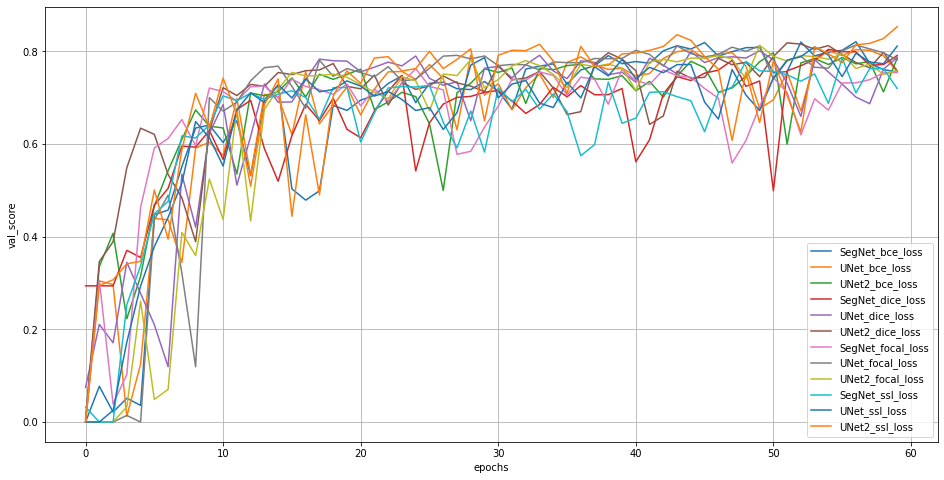

In [ ]:
plt.figure(figsize=(16, 8))
for label in losses.keys():
    plt.plot(segnet_val_score[label], label='SegNet_' + label)
    plt.plot(unet_val_score[label], label='UNet_' + label)
    plt.plot(unet2_val_score[label], label='UNet2_' + label)
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("val_score")
plt.grid()
plt.show()

Почти все *score* идут кучно, выделяются только *SegNet_ssl_loss* и *SegNet_dice_loss* - где видны систематические и досточно серьезные просадки. 

Рассмотрим каждую модель отдельно:

In [ ]:
models_res = {'SegNet': segnet_val_score,
              'UNet': unet_val_score, 
              'UNet2': unet2_val_score}

In [ ]:
def model_plot(model_name): 
    plt.figure(figsize=(16, 8))
    for label in losses.keys():
        plt.plot(models_res[model_name][label], label=model_name + '_' + label)
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("val_score")
    plt.title(model_name)
    plt.grid()
    plt.show()

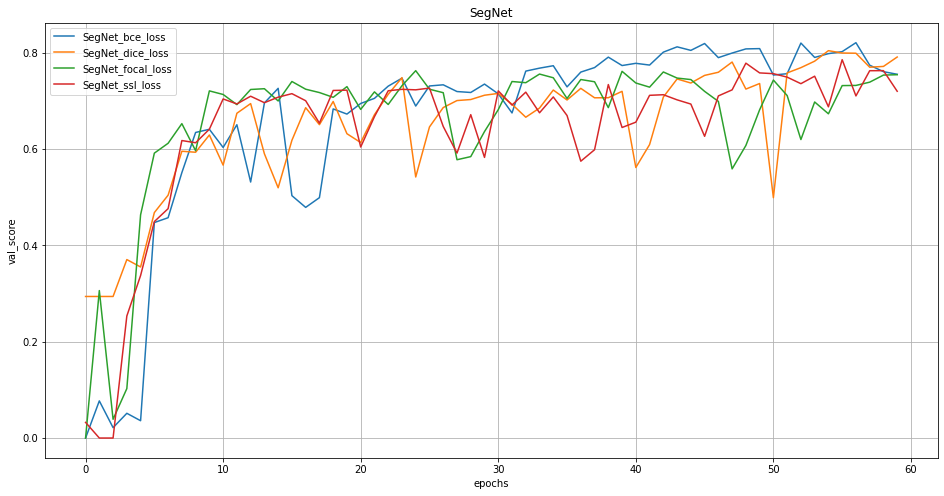

In [ ]:
model_plot('SegNet')

У *SegNet* наблюдается нестабильное поведение *score* на всех функциях потерь, кроме *bce_loss*. Лучший *score* данной модели достигается тоже на *bce_loss*.

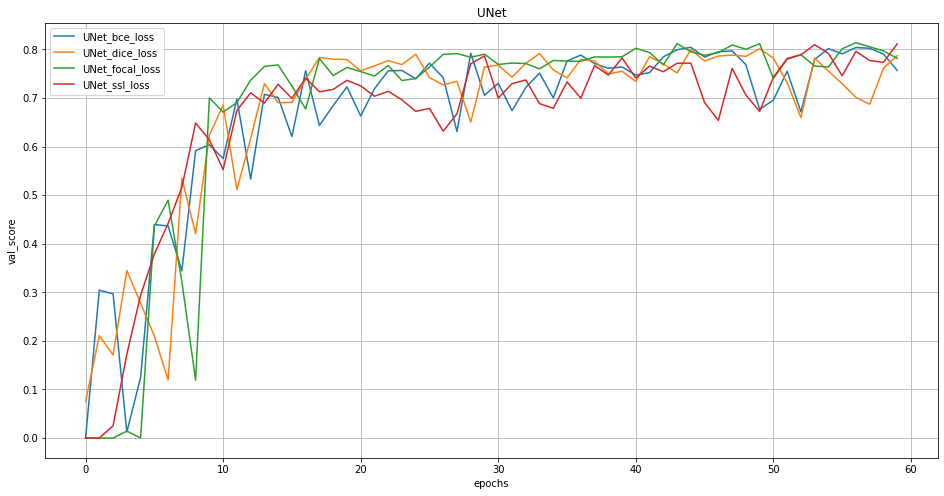

In [ ]:
model_plot('UNet')

У UNet, в отличие от SegNet, наоборот, все графики идут кучно, и почти нет сильных отклонений. Причем, почти на всем обучении, *score* при *focal_loss* был выше *score* при всех остальных функциях. 

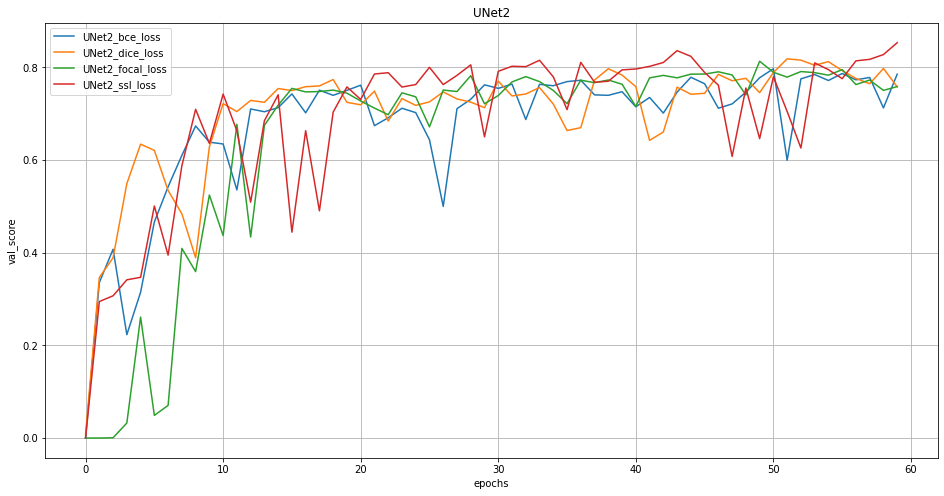

In [ ]:
model_plot('UNet2')

Стабильность UNet2 лучше, чем у SegNet, но хуже, чем у UNet. При этом, большую часть времени лучший *score* показывала *ssl_loss*, в то же время у *ssl_loss* наблюдается наиболее нестабильное поведение, наравне с *bce_loss*.

#### Графики score от модели для каждой *loss*-функции

In [ ]:
losses.keys()

dict_keys(['bce_loss', 'dice_loss', 'focal_loss', 'ssl_loss'])

In [ ]:
def loss_func_plot(loss_func_name): 
    plt.figure(figsize=(16, 8))
    for model_name, model_res in models_res.items():
        plt.plot(model_res[loss_func_name], label=model_name)

    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("val_score")
    plt.title(loss_func_name)
    plt.grid()
    plt.show()

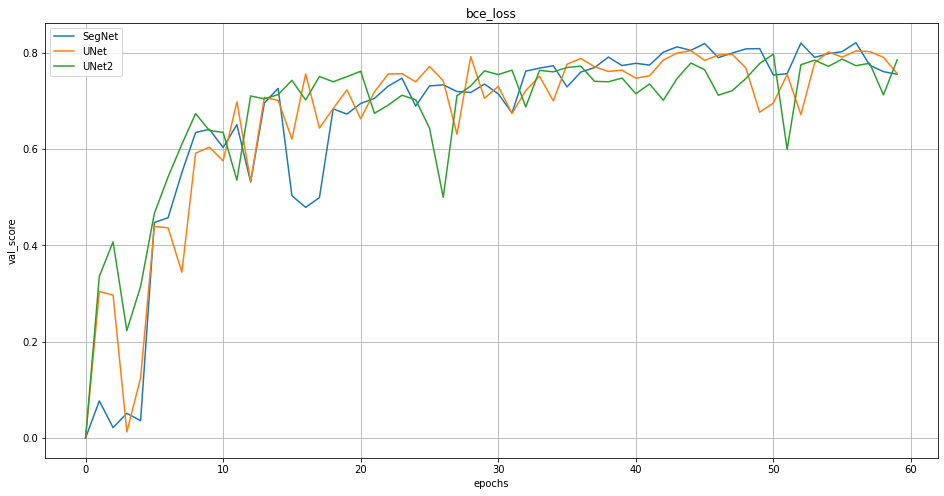

In [ ]:
loss_func_plot('bce_loss')

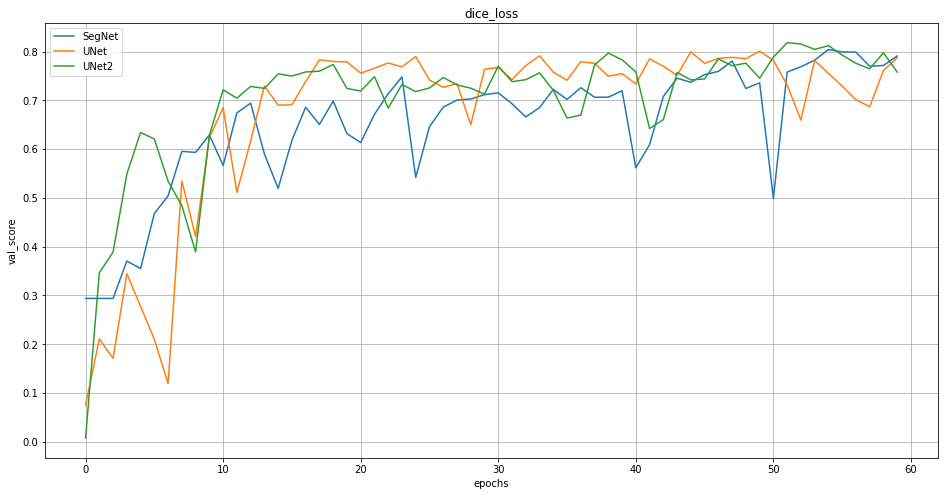

In [ ]:
loss_func_plot('dice_loss')

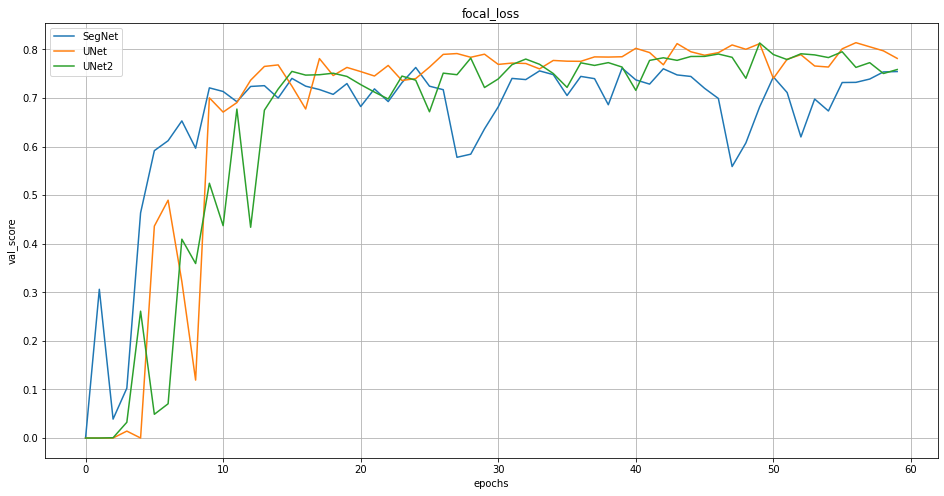

In [ ]:
loss_func_plot('focal_loss')

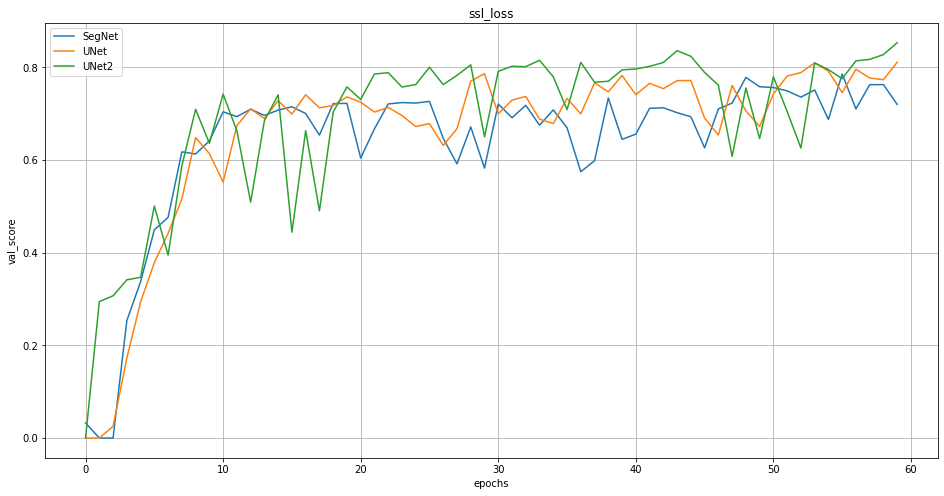

In [ ]:
loss_func_plot('ssl_loss')

На графиках видно, что при каждой отдельно взятой функции потерь UNet и UNet2 дают либо лучший результат, либо результат близкий к наилучшему. При этом SegNet сильно хуже при всех функциях, кроме *bce_loss*.

### Таблица результатов

Построим таблицу со всеми результатами на тестовой выборке и валидационной выборке (для каждой пары (модель, функция) выделим лучший результат на валидационной выборке за все эпохи):

In [ ]:
segnet_valid_best = {}
unet_valid_best = {}
unet2_valid_best = {}
for label, _ in losses.items(): 
    segnet_valid_best[label] = max(segnet_val_score[label])
    unet_valid_best[label] = max(unet_val_score[label])
    unet2_valid_best[label] = max(unet2_val_score[label])

In [ ]:
import pandas as pd 
df_ts = pd.DataFrame(np.array([list(test_res_segnet.values()), 
                              list(test_res_unet.values()), 
                              list(test_res_unet2.values())]), 
                    columns=list(losses.keys()),
                    index=['Segnet', 'UNet', 'UNet2'])
df_ts

,bce_loss,dice_loss,focal_loss,ssl_loss
Segnet,0.820146,0.823738,0.759094,0.785057
UNet,0.839198,0.831369,0.834553,0.834555
UNet2,0.818684,0.756937,0.803163,0.864744


In [ ]:
df_val = pd.DataFrame(np.array([list(segnet_valid_best.values()), 
                                list(unet_valid_best.values()), 
                                list(unet2_valid_best.values())]), 
                      columns=list(losses.keys()),
                      index=['Segnet', 'UNet', 'UNet2'])
df_val

,bce_loss,dice_loss,focal_loss,ssl_loss
Segnet,0.820903,0.804336,0.762794,0.785628
UNet,0.804299,0.801186,0.813814,0.811292
UNet2,0.797094,0.818404,0.813281,0.853317


Лучший результат показала пара (UNet2, ssl_loss). Но стоит отметить, что в среднем UNet выдавала более стабильный результат, что на тестовой выборке, что на валидационной, и, если судить по результатам на тестовой выборке, была лучше всех остальных, за исключением (UNet2, ssl_loss).

### Выводы

Таким образом, UNet является лучшим вариантом для первого обучения сегментации, так как не проваливается ни при одной функции потерь, а также имеет стабильное поведение при каждой из них. 

UNet2 также показывает хороший результат, достигает наилучшего результата среди всех моделей, но менее стабильна и результаты при разных функциях потерь сильно разнятся. 

SegNet же имеет худшие показатели среди всех трех моделей. 


Также нестабильность обучения можно связать с малым количеством данных, а также отсутствием аугментации. 

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.